In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import os
import json

plt.style.use("ggplot")

In [7]:
competition = 'asl-signs'

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('..') / 'input'  / 'competition'
    # !pip install -Uqq fastai
else:
    import zipfile, kaggle
    path = Path.home() / '.data' / 'asl-signs'
    if not path.exists():
        path.mkdir(exist_ok=True)
        kaggle.api.competition_download_cli(competition, path=path)
        zipfile.ZipFile(path / f'{competition}.zip').extractall(path)

# Labeled Data

In [8]:
with open(path / 'sign_to_prediction_index_map.json') as f:
    sign_labels = json.load(f)

In [9]:
train = (pd.read_csv(path / 'train.csv')
         .assign(idx=lambda x: x.participant_id.astype(str) + '_' + x.sequence_id.astype(str))
         .set_index('idx')
        )
train.head()

,path,participant_id,sequence_id,sign
idx,,,,
26734_1000035562,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
28656_1000106739,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
16069_100015657,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
25571_1000210073,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
62590_1000240708,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


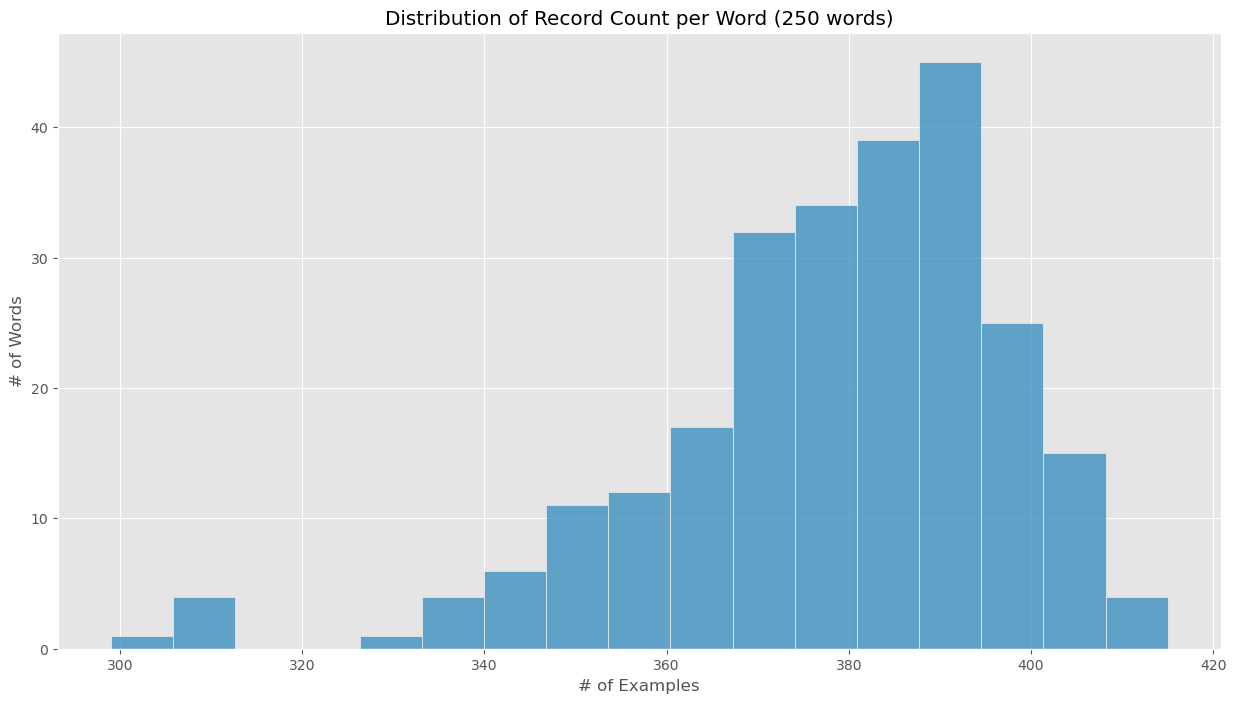

In [10]:
fig, ax = plt.subplots(figsize=(15, 8))
s = train.sign.value_counts()
ax = sns.histplot(s)
ax.set(xlabel='# of Examples', ylabel='# of Words', 
       title=f'Distribution of Record Count per Word ({len(s)} words)')
plt.show()

# Competition Data Loader

In [11]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

# Plotly Check Record Check

In [21]:
COORD_COLS = ['x', 'y', 'z']

def sample_by_sign(sign):
    mask = train.loc[:, 'sign'] == sign
    sample = train.loc[mask, :].sample(n=1, random_state=69)
    
    landmarks = pd.read_parquet(path / sample['path'].values[0])
    landmarks = landmarks.loc[~landmarks.loc[:, COORD_COLS].isna().all(axis=1), :]
    
    return sample, landmarks

# Plotly Dynamic Plot

In [42]:
landmarks.groupby('type')[['landmark_index', 'frame']].nunique()

,landmark_index,frame
type,,
face,468,16
pose,33,16
right_hand,21,16


In [25]:
sample, landmarks = sample_by_sign('bird')

lh_mask = landmarks.type == 'right_hand'
landmarks_lh = landmarks.loc[lh_mask, ]

frames = landmarks.frame.unique().tolist()

In [33]:
def create_landmark_lines(frame_landmarks):
    empty_row = pd.Series({
        'frame': None, 'row_id': None, 'type': None, 'x': None, 'y': None, 'z': None
    })
    frame_landmarks = frame_landmarks.set_index('landmark_index')
    line_indices = [0, 1, None, 0, 5, None, 0, 17, None, 
                    1, 2, 3, 4, None,
                    5, 6, 7, 8, None,
                    5, 9, None,
                    9, 10, 11, 12, None,
                    9, 13, None,
                    13, 14, 15, 16, None,
                    13, 17, None,
                    17, 18, 19, 20, None
                   ]
    lines = pd.DataFrame([frame_landmarks.loc[i, ] if i is not None else empty_row
                          for i in line_indices
                         ])
    return lines

In [37]:
import plotly.graph_objects as go

fig = go.Figure()

frames = landmarks_lh.frame.unique().tolist()
for frame in frames:
    frame_landmarks = landmarks_lh.loc[landmarks_lh.frame == frame, :]
    fig.add_trace(
        go.Scatter3d(
            visible=False, 
            x=frame_landmarks.x, y=frame_landmarks.y, z=frame_landmarks.z, text=frame_landmarks.landmark_index,
            marker=dict(size=8, opacity=0.8),
            mode="markers"
        )
    )


for frame in frames:
    frame_landmarks = landmarks_lh.loc[landmarks_lh.frame == frame, :]
    landmark_lines = create_landmark_lines(frame_landmarks)
    fig.add_trace(
        go.Scatter3d(
            visible=False, 
            x=landmark_lines.x, y=landmark_lines.y, z=landmark_lines.z,
            mode="lines",
            hoverinfo='skip'
        )
    )

steps = list()
for i, frame in enumerate(frames):
    step = dict(
        method='update',
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + str(frame)}],
        label=str(frame),
        value=i
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][i + len(frames)] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={'prefix': "Frequency: "},
    pad={'t': 50},
    steps=steps
)]

offset = 0.05
fig.update_layout(
    sliders=sliders,
    scene = dict(
       xaxis = dict(nticks=4, range=[landmarks_lh.x.min() - offset, landmarks_lh.x.max() + offset],),
       yaxis = dict(nticks=4, range=[landmarks_lh.y.min() - offset, landmarks_lh.y.max() + offset],),
       zaxis = dict(nticks=4, range=[landmarks_lh.z.min() - offset, landmarks_lh.z.max() + offset],)
    )
)

fig.show()